In [1]:
import numpy as np
from numpy.random import random_integers
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
from scipy.stats import pointbiserialr, spearmanr
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
path = '~/Documents/DSE/Data/HW3_220/Titanic/'
df = pd.read_csv(path+'train.csv')

Looking at our dataframe

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


####Process Data

We do not need Cabin and Ticket and hence can be dropped from our DataFrame.

We also can combine SibSp and Parch to FamilySize.

We can also replace Name with NameLength as richer people tended to have longer names.

In [4]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df['NameLength'] = df['Name'].apply(lambda x: len(x))
df = df.drop(['Ticket', 'Cabin', 'Name'], axis=1)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,NameLength
0,1,0,3,male,22.0,1,0,7.2500,S,1,23
1,2,1,1,female,38.0,1,0,71.2833,C,1,51
2,3,1,3,female,26.0,0,0,7.9250,S,0,22
3,4,1,1,female,35.0,1,0,53.1000,S,1,44
4,5,0,3,male,35.0,0,0,8.0500,S,0,24


Now let's check for data types and missing values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
FamilySize     891 non-null int64
NameLength     891 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 76.6+ KB


We can see that Age and Embarked has missing data. 

Embarked only has 2 NaNs and can be dropped. Age however has 177 NaNs.

Simply dropping the Age NaNs would mean throwing away too much data. 

We can simply standardize our Age column and replace the NaNs with 0.

In [6]:
Age=df['Age'].fillna(value=df.Age.mean())

In [7]:
#Process Age
df['Age']=df['Age'].fillna(value=df.Age.mean())
df['Age']=df['Age']/(df['Age'].max()-df['Age'].min())

#Process Fare
df['Fare']=df['Fare'].fillna(value=df.Fare.mean())
df['Fare']=df['Fare']/(df['Fare'].max()-df['Fare'].min())

#Process NameLength
df['NameLength']=df['NameLength']/(df['NameLength'].max()-df['NameLength'].min())

df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,NameLength
0,1,0,3,male,0.276451,1,0,0.014151,S,1,0.328571
1,2,1,1,female,0.477507,1,0,0.139136,C,1,0.728571
2,3,1,3,female,0.326715,0,0,0.015469,S,0,0.314286
3,4,1,1,female,0.439809,1,0,0.103644,S,1,0.628571
4,5,0,3,male,0.439809,0,0,0.015713,S,0,0.342857


Now we deal with categorical data.

In [8]:
dummies_Sex=pd.get_dummies(df['Sex'],prefix='Sex')
dummies_Embarked = pd.get_dummies(df['Embarked'], prefix= 'Embarked') 
dummies_Pclass = pd.get_dummies(df['Pclass'], prefix= 'Pclass')
df = pd.concat([df, dummies_Sex, dummies_Embarked, dummies_Pclass], axis=1)
df = df.drop(['Sex','Embarked','Pclass'], axis=1)

df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,FamilySize,NameLength,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,0.276451,1,0,0.014151,1,0.328571,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,1,0.477507,1,0,0.139136,1,0.728571,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,1,0.326715,0,0,0.015469,0,0.314286,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,1,0.439809,1,0,0.103644,1,0.628571,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,5,0,0.439809,0,0,0.015713,0,0.342857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


Finally, we set our PassengerId as our index.

In [9]:
df = df.set_index(['PassengerId'])
df.head()

,Survived,Age,SibSp,Parch,Fare,FamilySize,NameLength,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,
1,0,0.276451,1,0,0.014151,1,0.328571,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,0.477507,1,0,0.139136,1,0.728571,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,0.326715,0,0,0.015469,0,0.314286,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0.439809,1,0,0.103644,1,0.628571,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,0,0.439809,0,0,0.015713,0,0.342857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


####Feature Selection

For feature selection, we will look at the correlation of each feature against Survived.

Based on our data types, we will use the following aglorithms:

- Spearman-Rank correlation for nominal vs nominal data

- Point-Biserial correlation for nominal vs continuous data

In [10]:
columns = df.columns.values

param=[]
correlation=[]
abs_corr=[]

for c in columns:
    #Check if binary or continuous
    if len(df[c].unique())<=2:
        corr = spearmanr(df['Survived'],df[c])[0]
    else:
        corr = pointbiserialr(df['Survived'],df[c])[0]
    param.append(c)
    correlation.append(corr)
    abs_corr.append(abs(corr))

#Create dataframe for visualization
param_df=pd.DataFrame({'correlation':correlation,'parameter':param, 'abs_corr':abs_corr})

#Sort by absolute correlation
param_df=param_df.sort_values(by=['abs_corr'], ascending=False)

#Set parameter name as index
param_df=param_df.set_index('parameter')

param_df

,abs_corr,correlation
parameter,,
Survived,1.000000,1.000000
Sex_female,0.543351,0.543351
Sex_male,0.543351,-0.543351
NameLength,0.332350,0.332350
Pclass_3,0.322308,-0.322308
Pclass_1,0.285904,0.285904
Fare,0.257307,0.257307
Embarked_C,0.168240,0.168240
Embarked_S,0.155660,-0.155660


Now that we have our correlation, we can use the Decision Tree classifier to see the score agaisnt feature space.

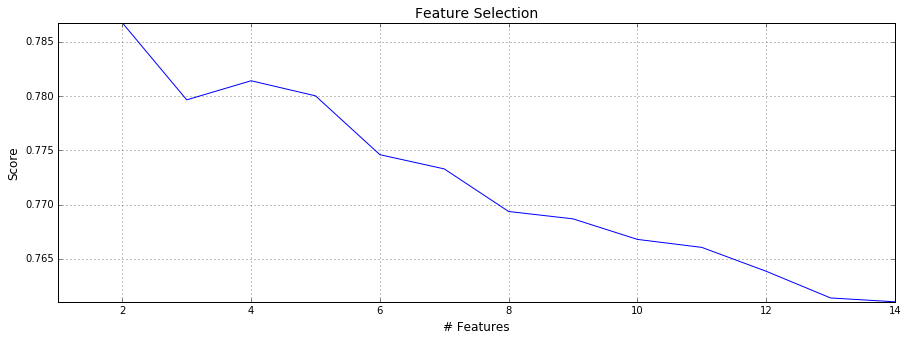

In [11]:
scoresCV = []
scores = []

for i in range(1,len(param_df)):
    new_df=df[param_df.index[0:i+1].values]
    X = new_df.ix[:,1::]
    y = new_df.ix[:,0]
    k_fold = sklearn.cross_validation.KFold(len(X), n_folds=10, shuffle=True, random_state=random_integers(1,50))
    for train_index, test_index in k_fold:
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        clf = DecisionTreeClassifier()
        clf.fit(X_train,y_train)
        score = clf.score(X_test,y_test)
        scoresCV.append(score)
    scores.append(np.mean(scoresCV))
    
plt.figure(figsize=(15,5))
plt.plot(range(1,len(scores)+1),scores)
plt.axis("tight")
plt.title('Feature Selection', fontsize=14)
plt.xlabel('# Features', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid();

Based on the plot, a feature space of 5 dimensions provides the most reliable result.

In [12]:
best_features=param_df.index[1:5+1].values
print 'Best features:\t',best_features

Best features:	['Sex_female' 'Sex_male' 'NameLength' 'Pclass_3' 'Pclass_1']


####Decision Tree

In [13]:
X = df[best_features]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.78644067796610173